# Practical Deep Learning for Coders, v3

# Lesson7_wgan

# wgan

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

## LSun bedroom data

## 起居室数据集

For this lesson, we'll be using the bedrooms from the LSUN dataset. The full dataset is a bit too large so we'll use a sample from kaggle.

本节课，我们将使用[LSUN dataset](http://lsun.cs.princeton.edu/2017/)的起居室数据集。整个数据集略大，因此这里我们只从[kaggle](https://www.kaggle.com/jhoward/lsun_bedroom)节选部分数据。

In [18]:
path = untar_data(URLs.MNIST)

In [3]:
path = Path('/home/dlinano/.fastai/data/mnist_png/training')

In [47]:
path = Path('/home/dlinano/.fastai/data/mnist_sample')

In [61]:
path = Path('/home/dlinano/.fastai/data/empty')

In [62]:
path

PosixPath('/home/dlinano/.fastai/data/empty')

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later. It consists of random noise of size 100 by default (can be changed below) as inputs and the images of bedrooms as targets. That's why we do tfm_y=True in the transforms, then apply the normalization to the ys and not the xs.

我们使用data block API抓取所有图片到文件夹中。我们不会创建一个独立验证集，原因后面我们会做解释。输入数据里包含了均值为100的随机噪声（也可以修改），并将起居室的图片作为目标。这也是我们在转换时，使用`tfm_y=True`参数，并且对ys而不是xs执行正规化操作的原因。

In [63]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

We'll begin with a small side and use gradual resizing.

我们将从小规模开始，逐步调整规模。

In [6]:
data = get_data(128, 16)

In [64]:
data_empty = get_data(128, 16)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [65]:
len(data_empty.train_ds)

1

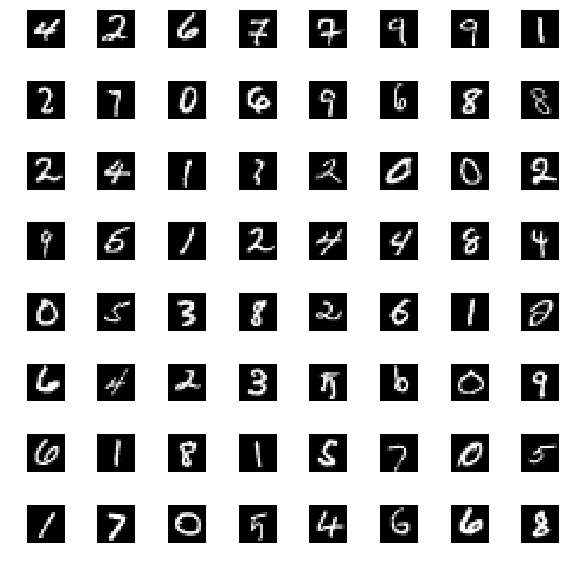

In [68]:
data.show_batch(rows=8,figsize=(8,8))

## Models 模型

GAN stands for Generative Adversarial Nets and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

GAN即生成对抗网络 [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)，该网络由Ian Goodfellow发明。其核心概念是我们将同时训练两个模型：一个生成器网络和一个评判网络。生成器网络将自创和数据集中的图片相似的新图片，而评判网络则试图从生成器生成的图片中分辨出真实的图片。生成器给出图片，评判网络则输出一个（作为评判结果的）值（通常0表示赝品,1表示真品）。

We train them against each other in the sense that at each step (more or less), we:

这两个网络每一步都在做对抗训练（或多或少可以这么解释），我们（如下这样操做）：

1.	Freeze the generator and train the critic for one step by:
    -	getting one batch of true images (let's call that real)
    -	generating one batch of fake images (let's call that fake)
    -	have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
    -	update the weights of the critic with the gradients of this loss


1. 冻结生成器训练评判网络:
  - 获取一批真品图片(我们简称为`真`)
  - 产生一批赝品图片(我们简称为`假`)
  - 让评判网络评估这批数据并计算出损失函数值；重要的一点是，如果判断为真就要给与奖励，反之，判断为假则予以惩罚。
  - 使用损失函数的梯度来更新评判网络的权重

2.	Freeze the critic and train the generator for one step by:
    - generating one batch of fake images
    - evaluate the critic on it
    - return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
    - update the weights of the generator with the gradients of this loss

2. 冻结评判网络训练生成器：
  - 产生一批赝品图片
  - 评判网络对这些图片进行评判
  - 返回损失（函数），这是评判网络得到的所有真实图片的回馈，它的重要作用是，探测出真实图片就给予奖励,反之则给予惩罚
  - 使用损失函数的梯度来更新生成器网络的权重

Here, we'll use the Wassertein GAN.

这里,我们将使用[Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf)这篇论文中的GAN网络。

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.<br><br>
我们将创建一个生成器和一个评判网络，把他们作为参数传给`gan_learner`。noise_size参数是生成器创造新图片时的随机向量的变动范围。

In [11]:
generator = basic_generator(in_size=16, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=16, n_channels=3, n_extra_layers=1)

In [24]:
??basic_generator

Signature:
basic_generator(
    in_size:int,
    n_channels:int,
    noise_sz:int=100,
    n_features:int=64,
    n_extra_layers=0,
    **conv_kwargs,
)
Source:   
def basic_generator(in_size:int, n_channels:int, noise_sz:int=100, n_features:int=64, n_extra_layers=0, **conv_kwargs):
    "A basic generator from `noise_sz` to images `n_channels` x `in_size` x `in_size`."
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < in_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [conv_layer(noise_sz, cur_ftrs, 4, 1, transpose=True, **conv_kwargs)]
    cur_size = 4
    while cur_size < in_size // 2:
        layers.append(conv_layer(cur_ftrs, cur_ftrs//2, 4, 2, 1, transpose=True, **conv_kwargs))
        cur_ftrs //= 2; cur_size *= 2
    layers += [conv_layer(cur_ftrs, cur_ftrs, 3, 1, 1, transpose=True, **conv_kwargs) for _ in range(n_extra_layers)]
    layers += [conv2d_trans(cur_ftrs, n_channels, 4, 2, 1, bias=False), nn.Tanh()]
    return nn.Sequential(*layers)
File:      /usr/local

In [25]:
??basic_critic

Signature:
basic_critic(
    in_size:int,
    n_channels:int,
    n_features:int=64,
    n_extra_layers:int=0,
    **conv_kwargs,
)
Source:   
def basic_critic(in_size:int, n_channels:int, n_features:int=64, n_extra_layers:int=0, **conv_kwargs):
    "A basic critic for images `n_channels` x `in_size` x `in_size`."
    layers = [conv_layer(n_channels, n_features, 4, 2, 1, leaky=0.2, norm_type=None, **conv_kwargs)]#norm_type=None?
    cur_size, cur_ftrs = in_size//2, n_features
    layers.append(nn.Sequential(*[conv_layer(cur_ftrs, cur_ftrs, 3, 1, leaky=0.2, **conv_kwargs) for _ in range(n_extra_layers)]))
    while cur_size > 4:
        layers.append(conv_layer(cur_ftrs, cur_ftrs*2, 4, 2, 1, leaky=0.2, **conv_kwargs))
        cur_ftrs *= 2 ; cur_size //= 2
    layers += [conv2d(cur_ftrs, 1, 4, padding=0), AvgFlatten()]
    return nn.Sequential(*layers)
File:      /usr/local/lib/python3.6/dist-packages/fastai/vision/gan.py
Type:      function


In [12]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [22]:
learn.model

GANModule(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Tanh()
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Leak

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.034311,#na#,0.029306,-0.047990,01:18
1,-0.033493,#na#,0.025554,-0.045806,01:18
2,-0.032491,#na#,0.025869,-0.045860,01:17
3,-0.033495,#na#,0.023524,-0.044733,01:18
4,-0.033193,#na#,0.020001,-0.043620,01:53
5,-0.031987,#na#,0.021621,-0.042622,01:32
6,-0.031201,#na#,0.022786,-0.042577,01:22
7,-0.029805,#na#,0.021926,-0.041002,01:20
8,-0.029085,#na#,0.023805,-0.040120,01:20
9,-0.029027,#na#,0.024338,-0.040116,01:21


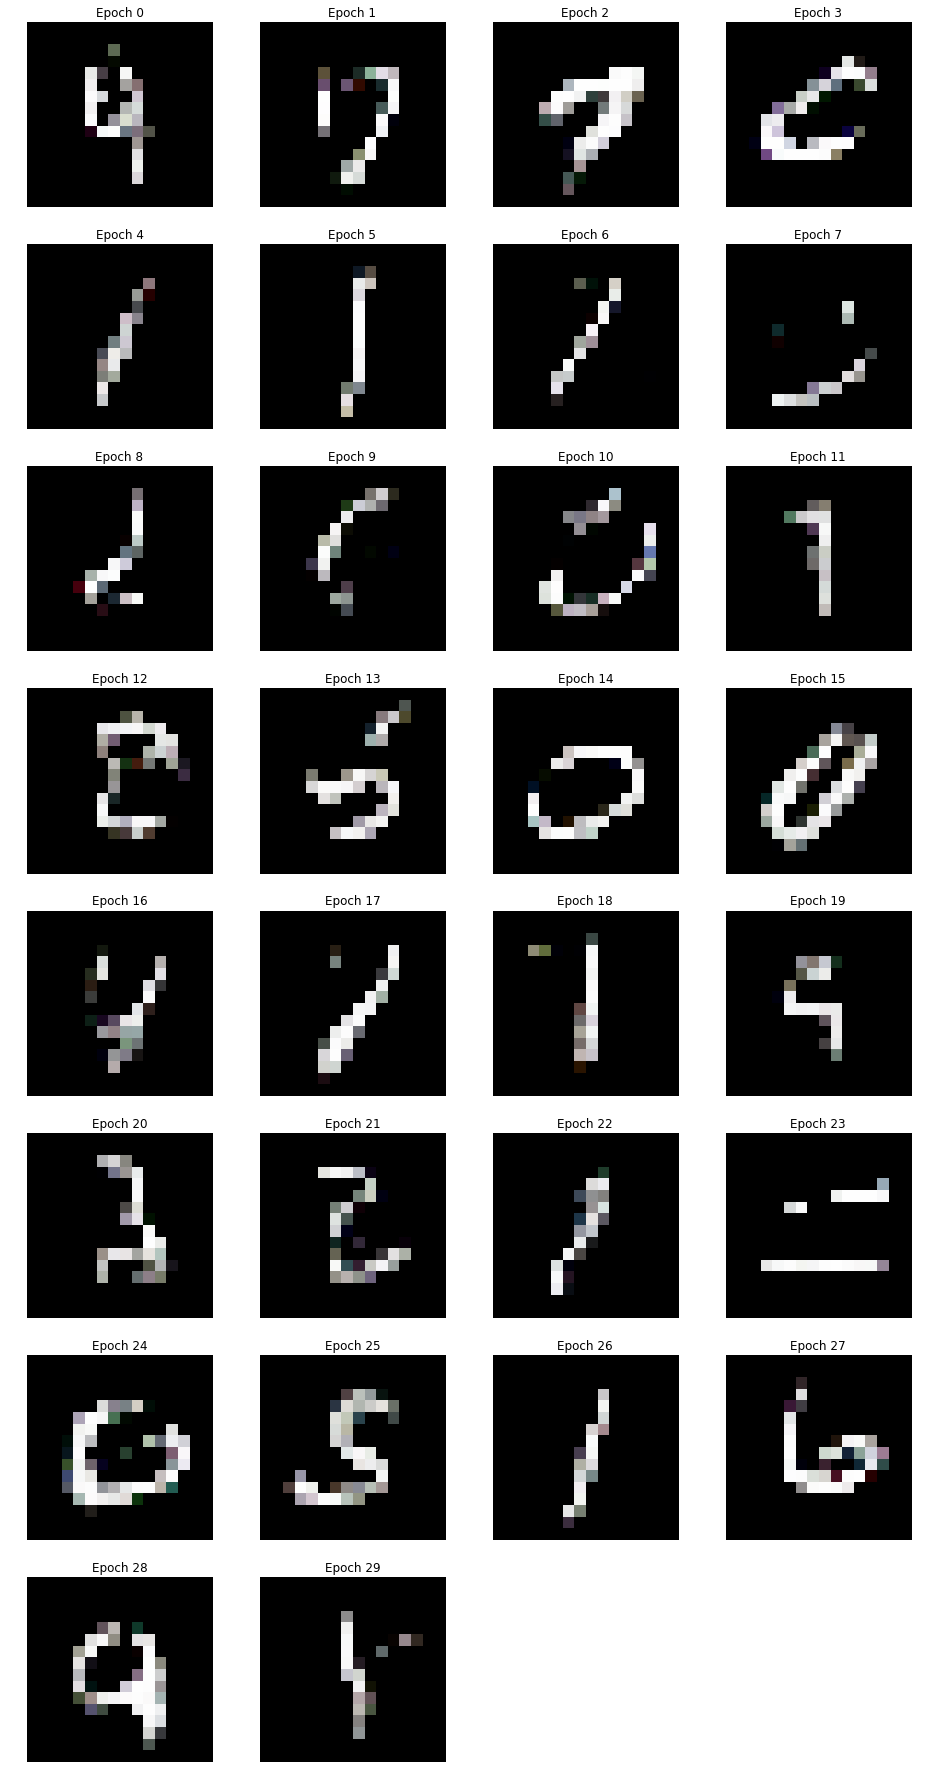

In [15]:
learn.fit(30,2e-4)

In [32]:
# learn.save('wgan-stage-1')

In [ ]:
learn.load('wgan-stage-1')

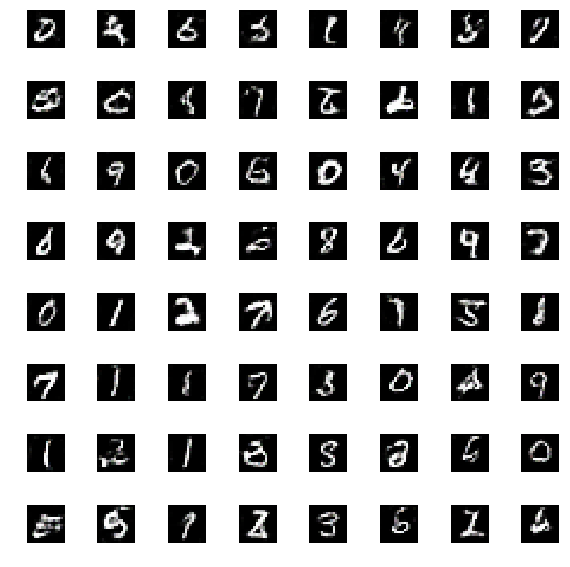

In [72]:
learn.gan_trainer.switch(gen_mode=True)
# learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(8,8))
learn.show_results(ds_type=None ,rows=8, figsize=(8,8))

In [31]:
learn.data

ImageDataBunch;

Train: LabelList (60000 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
Path: /home/dlinano/.fastai/data/mnist_png/training;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /home/dlinano/.fastai/data/mnist_png/training;

Test: None

In [ ]:
??learn